# Section 09: mixed feelings

Liana Merk (2024), adapted from Angel Tang, Verena Volf, Hope Merens, and Joseph Sedlak's notes from the past years. 


In [1]:
import numpy as np

import scipy.stats   as stats
import scipy.special as special

# For interactive plotting
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

np.random.seed(7)

## Part 1: K-Means

### The Problem

How can we computationally classify single objects together, based on their similarity to each other? In molecular biology and genetics research, it is very common to try to classify cell subtypes, such as neuronal subtypes or cancer cell subtypes in a heterogeneous tumor, based on their transcriptome. For instance, we may assume that varying expression levels of a few genes define the cell subtypes we are interested in. In this case, however, we do not have labeled data, and therefore must use unsupervised methods to group together cells with similar expression levels into the correct subtypes. It's important to remember that *because* we don't have ground truth, the definition of a cluster is imperfect, but can be used as a prox

Today, we will use expectation-maximization in order to conduct 1) k-means clustering and 2) mixture modeling as approaches to clustering similar data points together. In the pset this week, we will see how the same logic can be applied to clustering together cells by their gene expression. 

### Overview of k-means clustering algorithm

The task is to assign $X_i$ (data points or observations) to a predefined number ($K$) of clusters. The k-means clustering algorithm takes an iterative process to assign points to clusters such that the total squared distance between the points and the centroid of their assigned cluster is minimized. The number of clusters $k$ has to be specified by user. 

We start with some randomly chosen centroids $\mu_k$. Then, the two steps - assignment and update - repeated until convergence.

**Assignment:** Assign each data point $X_i$ to its closest centroid $Î¼_k$.

**Update**: Calculate new centroids $\mu_k$ based on newly assigned clusters.

Convergence occurs when the assignments stop changing.

**A note about empty clusters**

It is possible to have empty clusters: centroids that don't have any points assigned. One way to avoid this is to pull one data point out of another cluster and assign it to the empty cluster. There are other ways of doing this as well (e.g. generate another random point) and you can decide what works best for your homework.

**A note on avoiding local minima**

$K$ means clustering is prone to local minima, and it's therefore important to consider your choice of initial conditions. Recall from lecture we have a few ways of initializing centroids, including:
- choose $K$ random points in space
- choose $K$ random points from $X$ and put the initial centroids there
- assign all points in $X$ randomly to clusters, then calculate centroids of these.


### Let's implement a 1-dimensional example

We will generate some clusters of data points with the following features:

- Number of clusters: $4$
- Means: $0$, $3.33$, $6.67$, and $10$
- Number of points in each cluster: $25$
- Distribution of each cluster: a normal distribution with variance $\sigma^2 = 0.5$

In [2]:
n_samples, var, means = 100, 0.5, np.linspace(0, 10, 4)

distributions = [np.random.normal(mean, var, size=n_samples // len(means)) for mean in means]
data = np.concatenate(distributions)

np.random.shuffle(data)

Let's take a look at our data

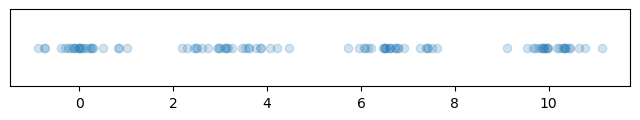

In [3]:
fig, ax = plt.subplots(figsize=(8, 1))
ax.plot(data, [1] * len(data), 'o', alpha=0.2)

ax.set_yticks([])
ax.set_ylim(0.5, 1.5)

plt.show()

Great! Now we want to move forward with $K$-means.

#### 1) K-means assignment step
$K$ clusters are created by assigning each data point $X_i$ to the nearest centroid $\mu_k$ based on their Euclidian distance in z dimensions $\sqrt{\sum_{z} (X_{iz}-\mu_{kz})^2}$, which is $\sqrt{(X_{i}-\mu_{k})^{2}}$ in this case of 1-dimensional points.

In [4]:
def assignment(coords, centers):
    """
    Assign each point to the closest center, calculating the closest center using argmin.
    """
    # Step 1: Assign each point to the closest center and calculate distances
    clusters = [np.argmin([np.sqrt((point - i)**2) for i in centers]) for point in coords]
    distances = [np.min([np.sqrt((point - i)**2) for i in centers]) for point in coords]
    
    # Step 2: Count points in each cluster
    cluster_counts = {i: 0 for i in range(len(centers))}
    for cluster in clusters:
        cluster_counts[cluster] += 1

    # Step 3: Check for empty clusters and reassign if necessary
    for cluster_idx in range(len(centers)):
        if cluster_counts[cluster_idx] == 0:
            clusters, distances = assign_empty(cluster_idx, clusters, distances)

    # Step 4: Calculate the total squared distance
    total_distance = sum(distances)

    return clusters, total_distance

Taking care of empty clusters:

In [5]:
def assign_empty(empty_cluster, clusters, distances):
    """
    Reassign the data point farthest from any current center to the specified empty cluster.
    """
    # Identify the index of the point farthest from its assigned center
    farthest_point_idx = np.argmax(distances)
    
    # Assign this point to the empty cluster and reset its distance to 0
    clusters[farthest_point_idx] = empty_cluster
    distances[farthest_point_idx] = 0
    
    return clusters, distances

#### 2) K-means update step
The centroid of the clusters are updated by calculating the mean of all points assigned to that cluster using $$\mu_{kz}=\frac{\sum_{i\in{C_k}} X_{iz}}{|C_k|}$$
For 1-dimensional centers, $$\mu_{k}=\frac{\sum_{i\in{C_k}} X_{i}}{|C_k|}$$

In [6]:
def update(coords, clusters, num_clust):
    """
    Update cluster centers by calculating the mean position of points assigned to each cluster.
    """
    coords = np.asarray(coords)
    clusters = np.asarray(clusters)
    
    # Calculate the updated centroids by averaging points in each cluster
    centers = [coords[clusters == x].mean(axis=0) for x in range(num_clust)]
    
    return centers

Now we'll do the actual iterations.

#### 3) K-means time!


In [7]:
def initialize_centroids(data, k):
    """
    Initialize k centroids by selecting random points from the dataset.
    """
    return np.random.choice(data, k, replace=False)

In [8]:
def plot_clustering(clusters, centroids, n_plots, title='Iteration'):
    """
    Plot clustering iterations.
    """
    # Select the iterations to plot based on the number of requested plots
    to_plot = np.linspace(0, len(centroids) - 1, num=n_plots, dtype=int)
    fig, axes = plt.subplots(n_plots, figsize=(8, n_plots * 2), sharex=True)

    # Ensure axes is an array even if n_plots=1
    if n_plots == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        # Current centroids and clustered data
        curr_centroids = centroids[to_plot[i]]
        curr_clusters = clusters[to_plot[i]]
        
        # Plot centroids as vertical lines
        ax.vlines(curr_centroids, ymin=0, ymax=2, colors='r', alpha=0.5, label='Centroids')
        
        # Plot data points in clusters
        for cluster in curr_clusters:
            ax.plot(cluster, np.ones_like(cluster), 'o', alpha=0.2)
        
        ax.set_title(f"{title} {to_plot[i] + 1}")
        ax.set_yticks([])
    
    # Adjust layout and show legend on the first plot only
    fig.tight_layout()
    axes[0].legend()
    plt.show()

In [9]:
def kmeans_1d_multi_run(data, k=2, max_iter=100, tolerance=1e-5, plot_iter=3, verbose=False, n_runs=20):
    """
    Run K-Means clustering multiple times and keep the best result based on the minimum total distance.
    """
    best_centroids = None
    best_clusters = None
    best_total_distance = float('inf')
    best_history_clusters = []
    best_history_centroids = []

    for run in range(n_runs):
        centroids = initialize_centroids(data, k)
        prev_centroids = np.zeros_like(centroids)
        iterations = 0
        convergence = False
        history_clusters, history_centroids = [], []

        while not convergence and iterations < max_iter:
            clusters, total_distance = assignment(data, centroids)
            prev_centroids = centroids.copy()
            centroids = update(data, clusters, k)
            convergence = np.allclose(centroids, prev_centroids, atol=tolerance)
            if plot_iter > 0:
                history_clusters.append([data[np.array(clusters) == i] for i in range(k)])
                history_centroids.append(centroids.copy())
            iterations += 1

        if total_distance < best_total_distance:
            best_total_distance = total_distance
            best_centroids = centroids.copy()
            best_clusters = clusters.copy()
            best_history_clusters = history_clusters.copy()
            best_history_centroids = history_centroids.copy()

    # Plot the best clustering progress if requested
    if plot_iter > 0:
        plot_clustering(best_history_clusters, best_history_centroids, plot_iter)

    if verbose:
        init_centroids = [round(float(c), 2) for c in (best_history_centroids[0] if best_history_centroids else best_centroids)]
        final_centroids = [round(float(c), 2) for c in best_centroids]
        print(f"K = {k}\nInitial centroids: {init_centroids}\nFinal centroids: {final_centroids}\n"
              f"Best total distance: {round(best_total_distance, 2)}\nConverged after {iterations} iterations")

    return best_centroids, best_clusters, best_total_distance

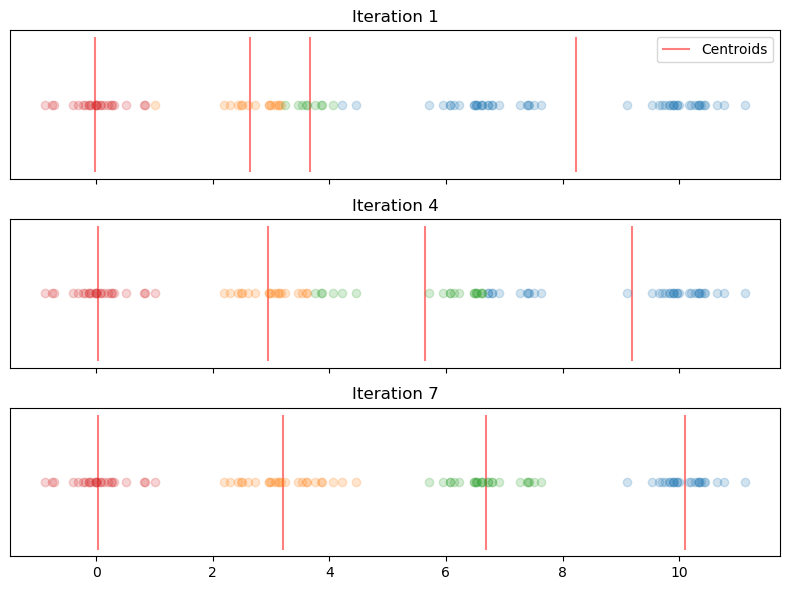

K = 4
Initial centroids: [8.24, 2.65, 3.67, -0.01]
Final centroids: [10.1, 3.21, 6.68, 0.03]
Best total distance: 39.62
Converged after 5 iterations


In [10]:
best_centroids, best_clusters, _ = kmeans_1d_multi_run(data, k=4, plot_iter=3, verbose=True, n_runs=20)

We can see that our classification of nearby points improved over the course of the iteration, and our final centroids end up being almost exactly the means underlying our data's distribution. Nice!

#### How do we determine the optimal number of clusters if we don't know the ground truth?

Sometimes we are uncertain about how many clusters there are, especially like RNA seq data that discovers novel cell types. One way to determine $K$ is to iterate through different $K$ values and choose the cutoff value where the steep decrease in the objective function stops.

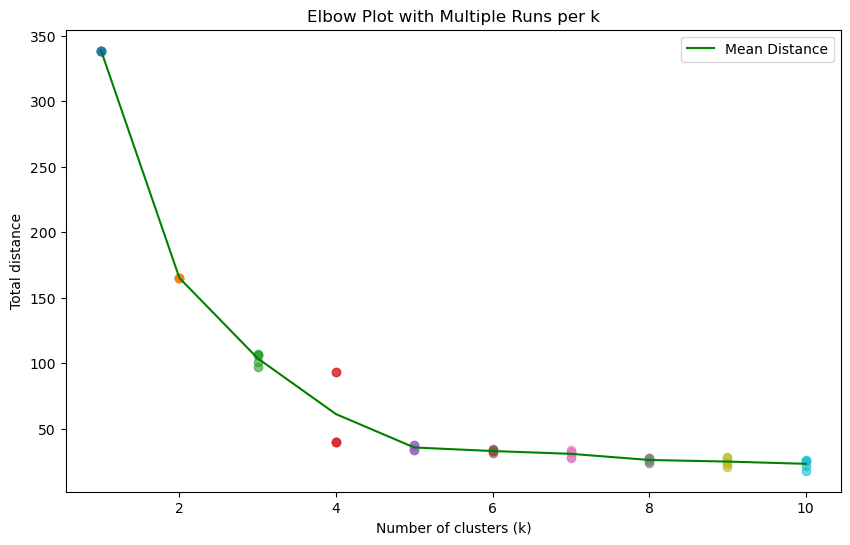

In [11]:
clust_range = range(1, 11)

def kmeans_1d_collect_distances(data, k, max_iter=100, tolerance=1e-5, n_runs=5):
    """Run K-Means multiple times for a given k and collect distances for each run."""
    distances = []
    for _ in range(n_runs):
        centroids = initialize_centroids(data, k)
        for _ in range(max_iter):
            clusters, total_distance = assignment(data, centroids)
            new_centroids = update(data, clusters, k)
            if np.allclose(centroids, new_centroids, atol=tolerance):
                break
            centroids = new_centroids
        distances.append(total_distance)
    return distances

# Collect and plot distances for each k
all_distances = [kmeans_1d_collect_distances(data, k) for k in clust_range]
plt.figure(figsize=(10, 6))
for k, distances in enumerate(all_distances, start=1):
    plt.scatter([k] * len(distances), distances, alpha=0.6)
plt.plot(range(1, 11), [np.mean(dist) for dist in all_distances], 'g-', label='Mean Distance')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total distance')
plt.title('Elbow Plot with Multiple Runs per k')
plt.legend(loc='upper right')
plt.show()

We can see there's a levelling off around 4 clusters, meaning we don't gain a lot of reduction in overall distance by increasing $K$. 

<div style="border: 1px solid #2196F3; background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
You are now an expert in 1-D $K$-means, for the set you will make this multi-dimensional!
</div>


________

## Part 2: Mixture Models

A mixture model is a generative probability model composed of other probability distributions. The idea is that our data are generated from a combinations of underlying probability distributions (one per cluster in our case). They don't all have to be the same distribution; they don't even have to be the same type of distribution (you can mix distributions any way you want). In this case, we are going to assume all our points were generated from 1 of $Q$ different Gaussian distribtions with parameters $\mu$ and $\sigma$. Since we are working with multiple Gaussian distributions, we need to add one more parameter, $\pi$, the mixing coefficient that is our best guess as to what fraction of the data was generated by each Gaussian.

We aim to optimize the parameters $\mu$ and $\pi$ and can choose arbitrary initial parameters. Similar to the pset (in which we use a negative binomial distribution instead of the Gaussian), our choice of sigma will be the same through every iteration. 

There are two main steps in the EM algorithm:

#### 1) Expectation Step (E-Step):
In this step, we aim to determine the probability that each data point $X_i$ belongs to each cluster $q$, given the current model parameters. This probability can be written as $P(q \mid X_i)$, following the Bayesian structure $P(\text{hypothesis} \mid \text{data})$. Using Bayes' theorem, we can express this as:

$$
P(q \mid X_i, \mu, \sigma, \pi) = \frac{P(X_i, q \mid \mu, \sigma, \pi)}{\sum_{q} P(X_i, q \mid \mu, \sigma, \pi)}
$$

This joint probability factors due to independence assumptions: selecting a Gaussian component is independent of selecting a data point from that component. Thus,

$$
P(X_i, q \mid \mu, \sigma, \pi) = P(X_i \mid q, \mu, \sigma) P(q \mid \pi)
$$

Luckily, these components are easily solvable on their own. The first is simply the likelihood of the data given a particular component. In this example, the components are all Gaussian, so $P(X \mid q,\mu,\sigma) = \frac{1}{\sqrt{2\sigma^{2}\pi}}e^{-\frac{(X-\mu)^{2}}{2\sigma^{2}}}$, i.e. the Gaussian PDF evaulauted at $X$ with $\sigma$ and $\mu$ from the given component $q$ ($\pi$ in that equation is number $\pi$ not the mixture coefficient $\pi$). Note that if $X_{i}$ had components $X_{ia}$ and $X_{ib}$, these can be assumed to be independent. Therefore, $P(X \mid q,\mu,\sigma)$ can be calculated separately for each component, and then the joint probability $P(X_{ia})*P(X_{ib})$ can be calculated.

1. $P(X_i \mid q, \mu, \sigma)$ represents the likelihood of the data given component $q$. Since each component is Gaussian, we have:

   $$
   P(X_i \mid q, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(X_i - \mu_q)^2}{2 \sigma^2}}
   $$


The $P(q \mid \pi)$ is even easier. It's just $\pi$ (the mixture coefficient $\pi$ not the number $\pi$). Recall that $\pi$ is defined as the fraction of the total data $X$ was generated by each Gaussian.

2. $P(q \mid \pi) = \pi_q$, the mixing coefficient, represents the fraction of the data generated by component $q$.

Thus, the posterior probability for component $q$ for any data point $X_i$ is:

$$
P(q \mid X_i, \mu, \sigma, \pi) = \frac{\pi_q P(X_i \mid q, \mu, \sigma)}{\sum_{q} \pi_q P(X_i \mid q, \mu, \sigma)}
$$

#### 2) Maximization Step (M-Step):
In this step, we use the posterior probabilities calculated in the E-step to update the model parameters, specifically the means $\mu_q$ and the mixing coefficients $\pi_q$:

1. **Mean (Centroid) Update**:
$$
\mu_q = \frac{\sum_{i} P(q \mid X_i, \mu, \sigma, \pi) \cdot X_i}{\sum_{i} P(q \mid X_i, \mu, \sigma, \pi)}
$$

2. **Mixing Coefficient Update**:
$$
\pi_q = \frac{\sum_{i} P(q \mid X_i, \mu, \sigma, \pi)}{N}
$$
where $N$ is the total number of data points.

#### Convergence Criterion
We track the total negative log-likelihood (NLL) of the data given the current parameters:

$$
\log P(X \mid \theta) = \sum_{i=1}^{N} \log \left( \sum_{q=1}^{Q} \pi_q P(X_i \mid \mu_q, \sigma) \right)
$$

The EM algorithm iterates between the E-step and M-step until the change in NLL falls below a predefined threshold, indicating convergence.


### We will again implement a 1-dimensional example

#### 1) Expectation
During this step, we calculate the posterior probability for each data point $x$ coming from each component $q$, which is given by $$
P(q \mid X_i, \mu, \sigma, \pi) = \frac{\pi_q P(X_i \mid q, \mu, \sigma)}{\sum_{q} \pi_q P(X_i \mid q, \mu, \sigma)}
$$.

We will also assign each point to a cluster for which it has the largest posterior probability.

In [12]:
def expectation(coords, mus, sigma, mix_coeffs):
    '''
    Return the Posterior Probability of each data point coming from each component 
    and current cluster assignment for each point.
    
    Parameters
    ----------
    coords       : list or 1D array, list of X-coordinates of all points
    mus          : list or 1D array, list of current estimates for component means
    sigma        : float, set parameter for component variance
    mix_coeffs   : list or 1D array, list of current estimates for mixture coefficients of components
    
    Returns
    -------
    posts        : 2D array, Posterior probabilities of each component being the source of each point.
    clusters     : list or 1D array, list of current cluster assignment for each point 
    '''
    
    # Initialize P(q|x)
    Pqx = []
    
    # Loop through points
    for point in coords: 
        # Calculate the probability that the point is generated by each component
        Pqx.append([pi * stats.norm.pdf(point, loc=mu, scale=sigma) for pi, mu in zip(mix_coeffs, mus)])
        
    # Normalize to obtain the posterior probability that each data point comes from each component
    posts = [np.array(x) / np.sum(x) for x in Pqx]
    
    # Assign clusters based on max posterior probability
    clusters = [np.argmax(p) for p in posts]
    
    return posts, clusters

### 2) Maximization
During this step, we update the centroids $\mu$ and mixture coefficient $\pi$ given the posterior probabilities.

The new centroid for each component $q$ is calculated as the posterior-weighted average of point positions, given by:
$$
\mu_q = \frac{\sum_i P(q \mid X_i) X_i}{\sum_i P(q \mid X_i)}
$$

The new mixture coefficient for each component is calculated as the mean of the posteriors for that component, given by:
$$
\pi_q = \frac{\sum_i P(q \mid X_i)}{N}
$$
where $N$ represents the total number of data points.


In [13]:
def maximization(coords, posts, mix_coeffs):
    '''
    Return the updated mu and mixture coefficient for each component
    
    Parameters
    ----------
    coords       : list or 1D array, X-coordinates of all points
    posts        : 2D array, Posterior probabilities of each component being the source of each point
    mix_coeffs   : list or 1D array, current estimates for mixture coefficients of components
    
    Returns
    -------
    mus          : list or 1D array, updated component means
    mix_coeffs   : list or 1D array, updated estimates for mixture coefficients of components 
    '''
    
    # Calculate the numerator for updating means
    # This is the sum of each (posterior probability * point) for each component
    num_mu = np.sum(posts * coords[:, np.newaxis], axis=0)
    
    # Calculate the denominator for updating means
    denom_mu = np.sum(posts, axis=0)
    
    # Update means (weighted averages)
    mus = num_mu / denom_mu
    
    # Update mixture coefficients as the average of the posteriors for each component
    mix_coeffs = denom_mu / np.sum(denom_mu)
    
    return mus, mix_coeffs

#### Calculating the Log-Likelihood of a Model
The likelihood of a model is defined as the probability that the observations are generated from the model. We can therefore use the log-likelihood to compare models and choose the one with the highest likelihood—that is, the smallest negative log-likelihood.

The likelihood of a model is given by:
$$
P(X \mid \theta) = \prod_i \sum_q \pi_q P(X_i \mid \theta_q)
$$

The log-likelihood is therefore given by:
$$
\log P(X \mid \theta) = \sum_i \log\left(\sum_q \pi_q P(X_i \mid \theta_q)\right) = \sum_i {\rm logSumExp}_q(\log \pi_q + \log P(X_i \mid \theta_q))
$$

Remember our friend the **log-sum-exp** trick, which we can use `scipy.special.logsumexp()` and `numpy.logaddexp()` for.

In [14]:
def negll(coords, mus, sigma, mix_coeffs):
    '''
    Return the negative log likelihood of data given the current mixture model
    
    Parameters
    ----------
    coords      : list or 1D array, list X-coordinates of all points
    mus         : list or 1D array, list of weighted/updated means    
    sigma       : float, standard deviation of the components
    mix_coeffs  : list or 1D array, list of current estimates for mixture coefficients of components
    
    Returns
    -------
    nll         : float, negative log likelihood of data given model
    '''
    
    # Compute the log-likelihood for each data point across all components
    log_probs = [[np.log(pi) + np.log(stats.norm.pdf(point, loc=mu, scale=sigma)) 
                  for pi, mu in zip(mix_coeffs, mus)] 
                 for point in coords]
    
    # Use logsumexp to stabilize the sum of log probabilities for each point
    ll = np.sum(special.logsumexp(log_probs, axis=1))
    
    # Return the negative log likelihood
    return -ll

Recall our data from earlier, which looks like this:

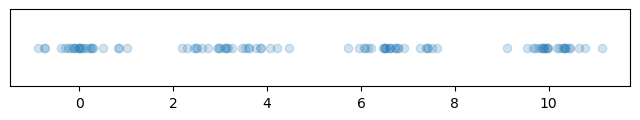

In [15]:
fig, ax = plt.subplots(figsize=(8, 1))
ax.plot(data, [1] * len(data), 'o', alpha=0.2)

# Remove y-axis ticks and adjust y-limits
ax.set_yticks([])
ax.set_ylim(0.5, 1.5)  # Ensures points are centered vertically

plt.show()

We now write a function to iterate throughour points, keeping track of the best parameters and reporting the final clusters.

In [16]:
def em_gmm(coords, K, sigma, tol=1e-4, max_iter=1000, n_runs=10):
    '''
    Perform the EM algorithm to fit a GMM to the data, tracking history.

    Parameters
    ----------
    coords      : 1D array, data points
    K           : int, number of Gaussian components
    sigma       : float, standard deviation of the components
    tol         : float, convergence threshold based on NLL change
    max_iter    : int, maximum number of iterations per run
    n_runs      : int, number of random initializations

    Returns
    -------
    best_params : dict, containing the best mus, mix_coeffs, clusters, and nll
    history     : list of dicts, each containing mus, mix_coeffs, clusters at each iteration
    '''
    best_nll = float('inf')
    best_params = {}
    history = []

    for run in range(n_runs):
        # Initialize mixture coefficients randomly and normalize
        mix_coeffs = np.random.rand(K)
        mix_coeffs /= mix_coeffs.sum()

        # Initialize means by randomly selecting data points without replacement
        mus = np.random.choice(coords, K, replace=False)

        # Initialize negative log-likelihood
        nll_old = float('inf')
        nll_diff = float('inf')
        iter_count = 0

        run_history = []

        for iteration in range(max_iter):
            # E-step
            posts, clusters = expectation(coords, mus, sigma, mix_coeffs)

            # M-step
            mus, mix_coeffs = maximization(coords, posts, mix_coeffs)

            # Compute negative log-likelihood
            nll = negll(coords, mus, sigma, mix_coeffs)

            # Store current state in history
            run_history.append({
                'mus': mus.copy(),
                'mix_coeffs': mix_coeffs.copy(),
                'clusters': clusters.copy(),
                'nll': nll
            })

            # Compute change in NLL
            nll_diff = abs(nll - nll_old)
            nll_old = nll

            iter_count += 1

            # Check for convergence
            if nll_diff < tol:
                break

        # Update the best parameters if current NLL is lower
        if nll < best_nll:
            best_nll = nll
            best_params = {
                'mus': mus.copy(),
                'mix_coeffs': mix_coeffs.copy(),
                'clusters': clusters.copy(),
                'nll': nll
            }
            history = run_history.copy()
            print(f'Run {run + 1}: Converged in {iter_count} iterations with NLL={nll:.4f}')

    return best_params, history

Let's run this.

In [17]:
# Parameters
num_clust = 4  # Should match the true number of components
beta = 0.5
sigma = np.sqrt(1 / (2 * beta))  # Given beta=0.5, sigma=1.0

# -------------------------------
# Here's where you may want to edit
# data to generate different mixtures.
# -------------------------------

# Run the EM algorithm and collect history
best_params, history = em_gmm(data, K=num_clust, sigma=sigma, tol=1e-4, max_iter=1000, n_runs=10)

# Extract best parameters
mus_est = best_params['mus']
mix_coeffs_est = best_params['mix_coeffs']
clusters_est = best_params['clusters']
nll_best = best_params['nll']

print("\nBest Estimated Parameters:")
print("Estimated Means:", mus_est)
print("Estimated Mixing Coefficients:", mix_coeffs_est)
print("Negative Log-Likelihood:", nll_best)

Run 1: Converged in 4 iterations with NLL=240.9882
Run 3: Converged in 10 iterations with NLL=240.9882
Run 5: Converged in 23 iterations with NLL=240.9882

Best Estimated Parameters:
Estimated Means: [ 6.65667144 10.07230614  0.08275953  3.1950666 ]
Estimated Mixing Coefficients: [0.25103834 0.25127565 0.25258185 0.24510415]
Negative Log-Likelihood: 240.9881771051168


We can see again our means are estimated to be very close to our actual generated data, and the prediction is that each gaussian is mixed with equal amount, since our mixing coefficient vector $\pi \approx 0.25$ for all $q.$

In [18]:
cmap = plt.get_cmap('viridis')

# Function to update the plot based on the iteration
def update_plot(iteration):
    clear_output(wait=True)  # Clear previous output
    plt.figure(figsize=(12, 6))  # Adjusted to match user's request

    # Get the parameters for the current iteration
    current_mus = history[iteration]['mus']
    current_mix_coeffs = history[iteration]['mix_coeffs']
    current_clusters = history[iteration]['clusters']

    # Assign colors to clusters
    colors = cmap(np.linspace(0, 1, num_clust))

    # Scatter plot of the data points slightly below the x-axis, colored by current cluster assignments
    plt.scatter(
        data,
        -0.05 * np.ones_like(data),  # Position data points slightly below the x-axis
        c=current_clusters,
        cmap='viridis',
        alpha=0.3,
        marker='o',
        edgecolor='k',
        label='Data Points'
    )

    # Define x-axis range for plotting the Gaussian components
    x = np.linspace(min(data) - 1, max(data) + 1, 1000)

    # Plot each Gaussian component with matching colors
    for k in range(num_clust):
        component_pdf = current_mix_coeffs[k] * stats.norm.pdf(x, current_mus[k], sigma)
        plt.plot(
            x,
            component_pdf,
            linestyle='--',
            alpha=0.6,
            color=colors[k],
            label=f'Component {k+1}'
        )

    # Plot the overall GMM
    gmm_pdf = np.sum([
        current_mix_coeffs[k] * stats.norm.pdf(x, current_mus[k], sigma) for k in range(num_clust)
    ], axis=0)
    plt.plot(
        x,
        gmm_pdf,
        color='black',
        label='Mixture Model'
    )

    # Aesthetics
    plt.title(f'Gaussian Mixture Model using EM Algorithm\nIteration {iteration + 1} of {len(history)}')
    plt.xlabel('Data Values')
    plt.ylabel('Density')
    plt.legend()
    plt.ylim(-0.1, max(gmm_pdf) + 0.1)  # Adjust y-axis to accommodate data points below the x-axis
    plt.yticks([])  # Hide y-axis ticks for clarity
    plt.show()

# Create an interactive slider
max_iteration = len(history) - 1
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=max_iteration,
    step=1,
    description='Iteration:',
    continuous_update=False,
    layout={'width': '80%'}
)

# Display the interactive plot
widgets.interact(update_plot, iteration=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Iteration:', layout=Layout(widt…

<function __main__.update_plot(iteration)>

Check out how the individual distributions and the larger mixture model change over the course of our EM iterations.

<div style="border: 1px solid #2196F3; background-color: #E3F2FD; padding: 10px; border-radius: 5px;">
You are now an expert in Gaussian Mixture Models, for the set you will do this with the negative binomial distribution. Let's look back at our plot above. Why are all the peaks the same height? Can you create input data that does not result in a plot like this, and how do you expect $\pi$ to change?
</div>

### closing formalities

In [19]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

jupyter   : 1.1.1
numpy     : 2.1.1
matplotlib: 3.9.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 12
Architecture: 64bit

